<a href="https://colab.research.google.com/github/skawngus1111/pytorch-cifar10-vgg-train/blob/main/pytorch-cifar10-vgg-train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import os
import random
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [107]:
configuration = {
    'A' : [64,     'M', 128,      'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'], # VGG11 network
    'B' : [64, 64, 'M', 128, 128, 'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'], # VGG13 network
    'C' : [64, 64, 'M', 128, 128, 'M', 256, 256, '256x1',  'M', 512, 512, '512x1',  'M', 512, 512, '512x1',  'M'], # VGG16 network with 1x1 conv
    'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'], # VGG16 network witout 1x1 conv
    'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']  # VGG19 network
}

class VGG(nn.Module) :
  def __init__(self, type, num_classes=10) :
    super(VGG, self).__init__()

    self.features = self._make_layers(type)

    self.classifier = nn.Sequential(
        nn.Linear(512, 4096), nn.ReLU(inplace=True), nn.Dropout(),
        nn.Linear(4096, 4096), nn.ReLU(inplace=True), nn.Dropout(),
        nn.Linear(4096, num_classes)
    )

  def forward(self, x) :
    output = self.features(x)
    output = output.view(output.size(0), -1)
    output = self.classifier(output)

    return output

  def _make_layers(self, config) :
    layers = []

    input_channels = 3
    for l in config :
      if l == 'M' : 
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        continue
      
      if 'x' in str(l) : 
        layers += [nn.Conv2d(input_channels, int(l.splits('x')[0]), kernel_size=1, padding=1)]
        continue

      layers += [nn.Conv2d(input_channels, l, kernel_size=3, padding=1)]

      layers += [nn.ReLU(inplace=True)]
      input_channels = l


    return nn.Sequential(*layers)

def get_model(type) :
  return VGG(configuration[type])

In [108]:
# get GPU 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Your device is {device}")

# fix seed
seed = 19960514
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if device == 'cuda' :
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

print(f"Your random seed is {seed}")

Your device is cuda
Your random seed is 19960514


In [109]:
# define hyper-parameters
BATCH_SIZE    = 128
LEARNING_RATE = 0.01
MOMENTUM      = 0.9
WEIGHT_DECAY  = 1E-4
EPOCHS        = 200
IMAGE_SIZE    = 32
TYPE          = 'A'
PRINT_STEP    = 100

In [110]:
# define transform=
train_transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

eval_transform = transforms.Compose([
                                      transforms.Resize(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [111]:
train_dataset = datasets.CIFAR10('./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=eval_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [112]:
model = get_model(TYPE).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [113]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [114]:
history = dict()
history['train_loss'] = list()
history['test_loss'] = list()
history['test_acc'] = list()

In [115]:
accumulate_process_time = 0
for epoch in tqdm_notebook(range(1, EPOCHS + 1)) :
  print('\n============ EPOCH {}/{} ============\n'.format(epoch, EPOCHS))
  epoch_start_time = time()

  print("TRAINING")
  model.train()
  running_loss = 0.0

  for batch_idx, (image, target) in enumerate(train_loader) :
    image, target = image.to(device), target.to(device)
    
    # forward propagation
    out = model(image)
    loss = criterion(out, target) # calculate loss function

    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss = running_loss * 0.9 + float(loss) * 0.1

    if (batch_idx + 1) % PRINT_STEP == 0 or (batch_idx + 1) == len(train_loader) :
      print(f"Epoch {epoch} | batch idx {batch_idx + 1}/{len(train_loader)}({np.round((batch_idx + 1)/ len(train_loader) * 100.0, 2)}%) COMPLETE | train loss {np.round(running_loss, 6)}")

  print("EVALUATE")
  model.eval()
  total_loss, total_correct = 0.0, 0
  
  with torch.no_grad() :
    for batch_idx, (image, target) in enumerate(test_loader) :
      image, target = image.to(device), target.to(device)

      # forward propagation
      out = model(image)
      loss = criterion(out, target) # calculate loss function
      pred = torch.argmax(F.softmax(out), dim=1) # get predict target
      total_loss += float(loss.data)
      total_correct += pred.eq(target).sum().item()

    test_loss = np.round(total_loss / len(test_loader.dataset), 6)
    test_acc = np.round(total_correct / len(test_loader.dataset), 6)

    print("Epoch {} | test loss : {} | test acc : {}({})".format(epoch, test_loss, test_acc, total_correct))


  total_epoch_time = time() - epoch_start_time
  accumulate_process_time += total_epoch_time
  epoch_m, epoch_s = divmod(total_epoch_time, 60)
  epoch_h, epoch_m = divmod(epoch_m, 60)
  acc_m, acc_s = divmod(accumulate_process_time, 60)
  acc_h, acc_m = divmod(acc_m, 60)

  history['train_loss'].append(np.round(running_loss, 6))
  history['test_loss'].append(test_loss)
  history['test_acc'].append(test_acc)

  print('\nEpoch {}/{} : train loss {} | test loss {} | test acc {} | took {} h {} m {} s | accumulate time {} h {} m {} s'.format(
    epoch, EPOCHS, history['train_loss'][-1], history['test_loss'][-1], history['test_acc'][-1], 
    int(epoch_h), int(epoch_m), int(epoch_s), int(acc_h), int(acc_m), int(acc_s)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



============ EPOCH 1/200 ============

TRAINING
Epoch 1 | batch idx 100/391(25.58%) COMPLETE | train loss 2.302815
Epoch 1 | batch idx 200/391(51.15%) COMPLETE | train loss 2.302577
Epoch 1 | batch idx 300/391(76.73%) COMPLETE | train loss 2.302697
Epoch 1 | batch idx 391/391(100.0%) COMPLETE | train loss 2.303332
EVALUATE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 | test loss : 0.018191 | test acc : 0.1(1000)

Epoch 1/200 : train loss 2.303332 | test loss 0.018191 | test acc 0.1 | took 0 h 0 m 20 s | accumulate time 0 h 0 m 20 s

============ EPOCH 2/200 ============

TRAINING
Epoch 2 | batch idx 100/391(25.58%) COMPLETE | train loss 2.303493
Epoch 2 | batch idx 200/391(51.15%) COMPLETE | train loss 2.30224
Epoch 2 | batch idx 300/391(76.73%) COMPLETE | train loss 2.303019
Epoch 2 | batch idx 391/391(100.0%) COMPLETE | train loss 2.302915
EVALUATE
Epoch 2 | test loss : 0.018195 | test acc : 0.1(1000)

Epoch 2/200 : train loss 2.302915 | test loss 0.018195 | test acc 0.1 | took 0 h 0 m 20 s | accumulate time 0 h 0 m 40 s

============ EPOCH 3/200 ============

TRAINING
Epoch 3 | batch idx 100/391(25.58%) COMPLETE | train loss 2.303272
Epoch 3 | batch idx 200/391(51.15%) COMPLETE | train loss 2.303286
Epoch 3 | batch idx 300/391(76.73%) COMPLETE | train loss 2.303032
Epoch 3 | batch idx 391/391(100.0%) COMPLETE | train loss 2.302539
EVALUA

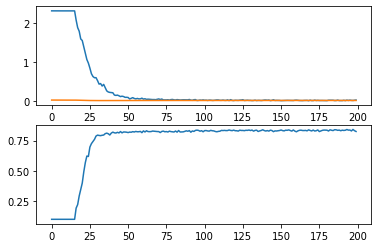

In [119]:
x = np.arange(EPOCHS)

fig, ax = plt.subplots(2, 1)
ax[0].plot(x, history['train_loss'])
ax[0].plot(x, history['test_loss'])
ax[1].plot(x, history['test_acc'])
plt.show()

In [128]:
result_df = pd.DataFrame(history)
if not os.path.exists(os.path.join('.', 'result')) : os.makedirs(os.path.join('.', 'result'))
result_df.to_csv('./result/loss.csv', index=False)

In [130]:
torch.save({
    'model' : model
}, './result/model_{}.pth'.format(TYPE))